In [35]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from urllib.parse import unquote
from torch.utils.data import Dataset, random_split, DataLoader
from tqdm import tqdm
from collections import Counter

In [2]:
# Load text data
data = pd.read_csv(f"../../data/full_text_data.csv")

In [3]:
# Load links
links = pd.read_csv("../../data/Wikispeedia/links.tsv", sep="\t", names=["src", "tgt"], skiprows=12)
links["src"] = links["src"].map(lambda x: unquote(x))
links["tgt"] = links["tgt"].map(lambda x: unquote(x))

In [4]:
# Load node embeddings
with open("../../data/gpt4_embeddings.pkl", 'rb') as handle:
    obj = pickle.load(handle)
    node_static_embeddings = obj["embeddings"]
    del obj
node_static_embeddings = torch.tensor(node_static_embeddings, dtype=torch.float)

/var/folders/62/lfsj8yr93_31q1svnw13n2km0000gn/T/ipykernel_20499/3588909332.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_static_embeddings = torch.tensor(node_static_embeddings, dtype=torch.float)


In [37]:
# Load user-extracted paths
paths_data = pd.read_csv(f"../../data/paths_no_back_links.tsv", sep="\t")
paths_data = paths_data[~(paths_data["rating"].isna())]

# Only paths with that have at least two distinct pages between the source and the the target
paths_data = paths_data[paths_data["path"].apply(lambda x: len(set(x.split(";")))) >= 4]
# paths_data = paths_data[paths_data["path"].apply(lambda x: len(set(x.split(";")))) <= 100]

# Map titles to indices
title_to_index = {unquote(title): idx for idx, title in enumerate(data['title'])}
paths = paths_data['path'].apply(lambda path: [title_to_index[unquote(title)] for title in path.split(';')]).tolist()
ratings = (paths_data['rating'] - 1).tolist()  # 0-indexed ratings
ratings = [0 if r < 2 else 1 for r in ratings]
durations = paths_data['durationInSec']

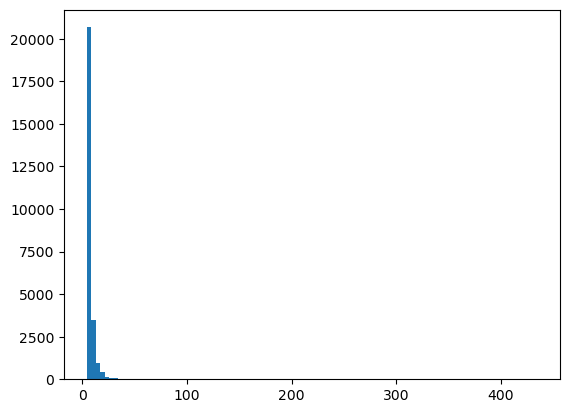

In [38]:
cnt = Counter([len(p.split(';')) for p in paths_data['path']])
#print(cnt)
plt.hist([len(p.split(';')) for p in paths_data['path']], bins=100)
plt.show()

In [32]:
old_max = 435
MAX_VALUE = (100*1536)+1
class PathDataset(Dataset):
    def __init__(self, paths, ratings, durations, node_embeddings):
        self.paths = paths
        self.ratings = ratings
        self.durations = durations
        self.node_embeddings = node_embeddings

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        rating = self.ratings[idx]
        
        nodes = list(set(path))
        x = self.node_embeddings[nodes]
        data = torch.cat((x.flatten(),torch.tensor(self.durations.values[idx]).unsqueeze(0)))

        if data.shape[0] != MAX_VALUE:

            # Calculate padding
            padding = MAX_VALUE - data.size(0)

            # Apply padding
            data = F.pad(data, (0, padding), mode='constant', value=0)
        return data, torch.tensor(rating, dtype=torch.long)
    
# Create dataset
dataset = PathDataset(paths, ratings, durations, node_static_embeddings)

# Split dataset
train_ratio = 0.85
val_ratio = 0.05
test_ratio = 0.1
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [17]:
print(dataset[0][0].shape)

torch.Size([153601])


/var/folders/62/lfsj8yr93_31q1svnw13n2km0000gn/T/ipykernel_20499/1584861040.py:28: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return data, torch.tensor(rating, dtype=torch.long)


In [18]:
class MLP(torch.nn.Module):
    def __init__(self, nodes_times_embdim, num_classes, dropout=0.1):
        super(MLP, self).__init__()
        self.l1 = torch.nn.Linear(in_features=nodes_times_embdim,
                                  out_features=nodes_times_embdim//160)
        self.l2 = torch.nn.Linear(in_features=nodes_times_embdim//160,
                                  out_features=num_classes)
        self.dropout = dropout
    
    def forward(self, x):
        x = self.l1(x)
        x = F.leaky_relu(x, 0.1)
        x = self.l2(x)
        F.log_softmax(x, dim=1)
        return x

In [19]:
greatest = 0
for p in paths_data["path"]:
    if len(p.split(';')) > greatest:
        greatest = len(p.split(';'))
print(greatest)

104


In [29]:
# Counts occurrences of each class
class_counts = torch.bincount(
    torch.tensor(ratings)[train_dataset.indices].to(torch.int64)
)

# Calculate weights as the inverse of class frequencies
class_weights = 1.0 / class_counts.float()

# Normalize the weights so that they sum to the number of classes
class_weights = class_weights / class_weights.sum() * len(class_counts)

class_weights

tensor([0.8493, 1.1507])

In [33]:
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
model = MLP(MAX_VALUE, 2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

def train():
    model.train()
    total_loss = 0
    for data, target in tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader.dataset)

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0

    confusion_matrix = np.array([[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += data.shape[0]

            for idx in range(data.shape[0]):
                confusion_matrix[target, pred[idx]] += 1


    return (correct / total), confusion_matrix

best_val_acc = 0
for epoch in range(1, 10):
    loss = train()
    val_acc, conf_mat = evaluate(val_loader)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

100%|██████████| 172/172 [01:57<00:00,  1.46it/s]


Epoch: 001, Loss: 0.0062, Val Acc: 0.6801


100%|██████████| 172/172 [01:59<00:00,  1.44it/s]


Epoch: 002, Loss: 0.0058, Val Acc: 0.6924


100%|██████████| 172/172 [01:55<00:00,  1.49it/s]


Epoch: 003, Loss: 0.0060, Val Acc: 0.7032


100%|██████████| 172/172 [02:04<00:00,  1.38it/s]


Epoch: 004, Loss: 0.0057, Val Acc: 0.6723


100%|██████████| 172/172 [01:56<00:00,  1.48it/s]


Epoch: 005, Loss: 0.0064, Val Acc: 0.6940


  5%|▌         | 9/172 [00:06<01:59,  1.36it/s]


KeyboardInterrupt: 